In [ ]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /tmp/pip-req-build-fn9q7wi3
  Running command git clone -q https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /tmp/pip-req-build-fn9q7wi3
  Created wheel for text-flappy-bird-gym: filename=text_flappy_bird_gym-0.0.1-py3-none-any.whl size=7637 sha256=dc338b0a4ac280920e32471c36c86386bdbdd5855c6ddd7e94c01960950f52eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-g07ltx93/wheels/e2/5d/b6/cc1694a6e6ec009fd74a95dfa085d68a665ebd6f8d8f0d5d59
Successfully built text-flappy-bird-gym


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/reinforcement_learning/project/')

In [ ]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt
from tqdm import tqdm


In [ ]:
import os, sys
import gym
import time

import text_flappy_bird_gym
from rl_glue import RLGlue
import agent
from collections import defaultdict
from plot_utils import plot_flappy_bird_values, plot_policy


In [ ]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

    # iterate
while True:

        # Select next action
        action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

        # Appy action and return new observation of the environment
        obs, reward, done, info = env.step(action)

        # Render the game
        os.system("clear")
        sys.stdout.write(env.render())
        time.sleep(0.2) # FPS

        # If player is dead break
        if done:
            break

env.close()


Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=12,y=-4)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=11,y=-5)
Text Flappy Bird!
Score: 0
----------------------
[         

In [ ]:
obs=env.reset()

In [ ]:
obs

(13, -3)

In [ ]:
sys.stdout.write(env.render())

Text Flappy Bird!
Score: 0
----------------------
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[                   |]
[      @            |]
[                    ]
[                    ]
[                    ]
[                    ]
[                   |]
[                   |]
[                   |]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (x=13,y=-3)


# implementation of the first agent:

the first agent implemented is the expected sarsa:<br> 
we can distinguish two main families of reinforcement learning techniques:
* On Policy: In this, the learning agent learns the value function according to the current action derived from the policy currently being used.
* Off Policy: In this, the learning agent learns the value function according to the action derived from another policy.<br>
sarsa is an on policy technique since it uses the action performed by the current policy to learn the Q-value.<br>
This following is the update equation for sarsa: $Q(s_t,a_t)=Q(s_t,a_t)+α(r_{t+1}+γQ(s_{t+1},a_{t+1})-Q(s_t,a_t))$ where $r_t$ is the reward at time t, $γ$ is the discount factor and $α$ is the learning rate.
<br> This update equation of this particular algorithm depends on the current state, next state and next action, we can actually write a sarsa that takes in account more steps, in that case it can be considered an n-step sarsa.
<br> expected sarsa is a slight variation of the sarsa algorithm: <br> we know infact that both our agents implemented (expected sars and (we'll see in the future) q-learning are algorithms that uses temporal difference updates to improve the agent behaviour.
<br> We know that sarsa is an on-policy technique, Q-learning is an off-policy technique, but expected sarsa can be use either as an on-policy or off-policy.
<br> Let's now compare the expected sarsa update equation with the sarsa update equation:
<b> expected sarsa:</b> $Q(s_t,a_t)+α(r_{t+1}+γ∑_aπ(a|s_{t+1}Q(s_{t+1},a)-Q(s_t,a_t))$ <br>
<b>sarsa: </b> $Q(s_t,a_t)=Q(s_t,a_t)+α(r_{t+1}+γQ(s_{t+1},a_{t+1})-Q(s_t,a_t))$ <br>
as is possible to see  expected sarsa takes the weighted sum of all possible next actions with respect to the probability of taking that action. If the Expected Return is greedy with respect to the expected return, then this equation gets transformed to Q-Learning.
<br> Importantly, because Sarsa is on-policy, it will not converge to optimal Q
values as long as exploration occurs. However, by annealing
exploration over time, Sarsa can converge to optimal Q
values, just like Q-learning, in my implementation i did't use an adaptive learning rate, because i wanted to compare learning rates in the two algorithms in the next sections


In [ ]:
from collections import defaultdict
f=defaultdict(lambda: np.zeros(3)) 

In [ ]:
class ExpectedSarsaAgent():
    
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
            seed(int):        the setted seed 
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        #self.x_state_tot=  agent_init_info["x_dim"]
        #self.y_state_tot=  agent_init_info["y_dim"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.num_actions)) 

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (tuple): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state=state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
        
        pol = self.epsilon/self.num_actions * np.ones(self.num_actions)
        pol[self.argmax(current_q)] = 1 - self.epsilon + self.epsilon/self.num_actions
        summ = np.sum(current_q * pol)
        self.q[self.prev_state][self.prev_action] += self.step_size * (reward + self.discount*summ - self.q[self.prev_state][self.prev_action])
       
        self.prev_state = state
        
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
  
        self.q[self.prev_state][self.prev_action] += self.step_size * (reward - self.q[self.prev_state][self.prev_action])
    
        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [ ]:
agent_info = {"num_actions": 2, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0,"seed":1}
n_runs=100
n_episodes=500
env=gym.make('TextFlappyBird-v0', height=15 , width=20 , pipe_gap = 4)
all_reward_sums= []

for run in tqdm(range(n_runs)):
  agent=ExpectedSarsaAgent()
  agent.agent_init(agent_info)
  agent_info["seed"] = run
  reward_sums = []
  for episode in range(n_episodes):
    init_state=env.reset()
    summ=0
    action=agent.agent_start(init_state)
    while True:
      obs, reward, done, info = env.step(action)
      summ=summ+reward
      action=agent.agent_step(reward,obs)
      if done:
        agent.agent_end(reward)
        break
    reward_sums.append(summ) #for each episode take the sum of rewards
  all_reward_sums.append(reward_sums) #a vector of vectors, that presents the sum of rewards for each episode, for each run
#now lets average it over the runs
mean_rewards_exp_sarsa=np.mean(all_reward_sums, axis=0)


  
    
env.close()



      
    






100%|██████████| 100/100 [02:01<00:00,  1.21s/it]


lets now play a game 

In [ ]:
env=gym.make('TextFlappyBird-v0', height=15 , width=20 , pipe_gap = 4)
init_state=env.reset()
summ=0
action=agent.agent_start(init_state)
while True:
      obs, reward, done, info = env.step(action)
      summ=summ+reward
      action=agent.agent_step(reward,obs)
      os.system("clear")
      sys.stdout.write(env.render())
      time.sleep(0.2) # FPS
      if done:
        agent.agent_end(reward)
        break

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (x=12,y=1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (x=11,y=2)
Text Flappy Bird!
Score: 0
----------------------
[           

as is possible to see the score reached is pretty high (22) 

lets now plot the value for each state

## analysis of the first agent

following is the plot of the state value function for the expected sarsa algorithm

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in agent.q.items())

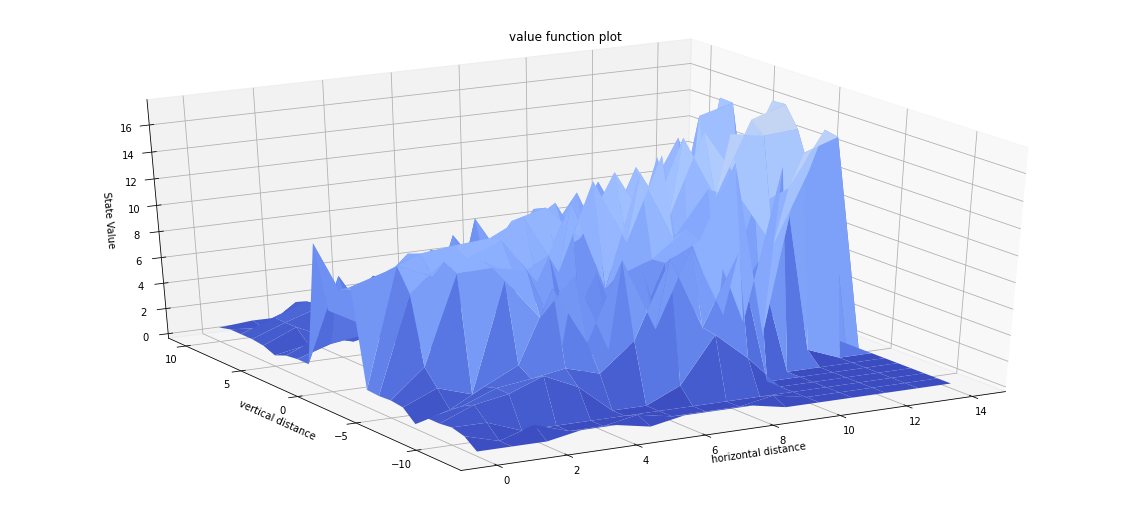

In [ ]:
plot_flappy_bird_values(V)

the graph plots the final value of all states, the x axes shows the horizontal distance of the bird from the gap, the y axes shows the vertical distances of the bird from the gap, the z axes shows the value corresponding to the state (horizontal distance, vertical distance).<br>
theoretically we want the state value function to be as high as possible for all states, because in this way the plot will tell us that we dont have some "unluky" state, that have a lower value compared to the rest, so as we increase the number of episodes, as is possible to see from the plot below, the value associated to each state will remain high:

100%|██████████| 100/100 [19:14<00:00, 11.54s/it]


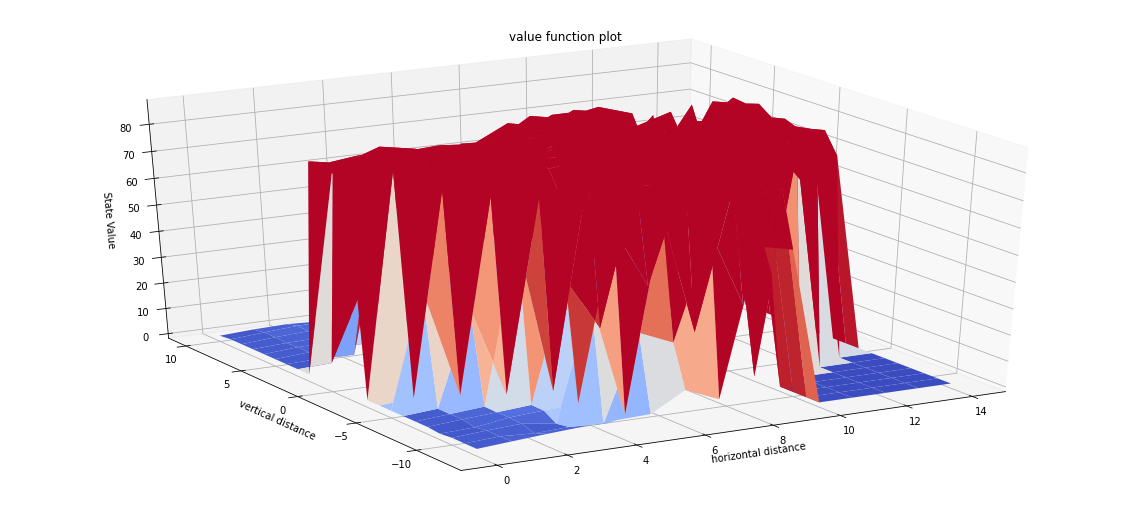

In [ ]:
agent_info = {"num_actions": 2, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0,"seed":1}
n_runs=100
n_episodes=2000 #increased n_episode
env=gym.make('TextFlappyBird-v0', height=15 , width=20 , pipe_gap = 4)
all_reward_sums= []

for run in tqdm(range(n_runs)):
  agent=ExpectedSarsaAgent()
  agent.agent_init(agent_info)
  agent_info["seed"] = run
  reward_sums = []
  for episode in range(n_episodes):
    init_state=env.reset()
    summ=0
    action=agent.agent_start(init_state)
    while True:
      obs, reward, done, info = env.step(action)
      summ=summ+reward
      action=agent.agent_step(reward,obs)
      if done:
        agent.agent_end(reward)
        break
    reward_sums.append(summ) #for each episode take the sum of rewards
  all_reward_sums.append(reward_sums) #a vector of vectors, that presents the sum of rewards for each episode, for each run
#now lets average it over the runs
mean_rewards_exp_sarsa=np.mean(all_reward_sums, axis=0)


  
    
env.close()
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in agent.q.items())
plot_flappy_bird_values(V)


however, as written below , the expected sarsa algorithm do not always converge to the optimal policy (see reasons below), to make it converge, we should decrease the learning rate with the training (as the number of episodes increases, the learning rate should decrease)

In [ ]:
policy = dict((k,np.argmax(v)) for k, v in agent.q.items())

here is our final policy plotted

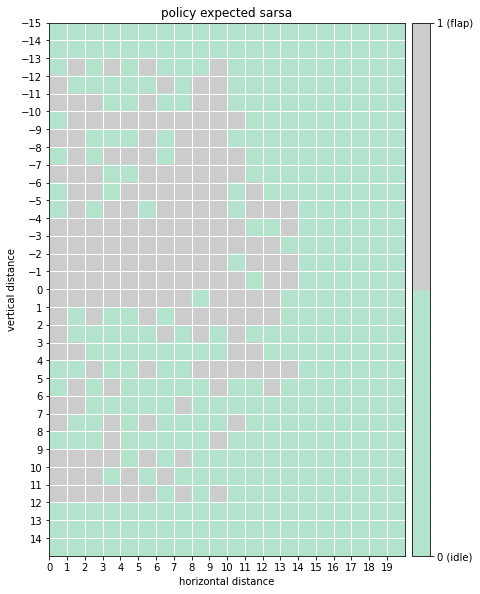

In [ ]:
plot_policy(policy)

for each state the little square color represent the action we should play if its green we should idle, if its gray we should flap. For example we can see that we should flap almost all the time if the player current vertical distance from the gap is below 0 and idle almost all the time if the vertical distance is above 0 to play the game optimally. We can compare this plot as a rulebook that tells us what are the actions to take for each possible state

lets now define the second agent(q-learning agent)

# implementation of the second agent

Q-learning is an off policy reinforcement learning algorithm that seeks to find the best action to take given the current state. It’s considered off-policy because the q-learning function learns from actions that are outside the current policy($ϵ-greedy)$ and therefore a policy isn’t needed. More specifically, q-learning seeks to learn a policy that maximizes the total reward(greedy policy).
the update rule is the following: 
$Q(s,a)=(1-α)Q(s,a)+\alpha(r+max_{a'}(Q(s',a'))$ where a' is the action chosen with the gredy policy, and a is rhe action choosen at each step ($ϵ-greedy)$, we clearly see that we are learning from a behaviour policy(ϵ-greedy) and we are evaluating our target policy (greedy) allowing them to improve at each step (td-learning). q-learning always converges to the optimal solution because is an off-policy learning algorithm. We are following the behaviour policy, $μ$, which is ϵ−greedy. This behaviour policy need not be an optimal policy rather it is a more explorable policy. But we are learning the target policy, π, which is argmax of state action value (Q(s,a)). This target policy is by definition optimal policy. however q -learning converges only given an adeguate exploration, in this case thee state space was pretty small (15x20x2) total possible states, so training for 500/1000 episodes was sufficient, but this is not the case if we used the original screen environment, in that case the state space would be enormous, and to use this algorithm we would need too much episodes, and this solution is not timely feasible.<br>
In that particular case i would have simply approximated the q-value function using a deep-q-learning algorithm(see next section)


#case study: approach for screen environment

let's now think of a situation in wich the environment is now TextFlappyBird-screenv0.<br>
This environment at each step returns the complete screen render of the
game, this differs much from the situation we had previously, in wich the environment only returned the x,y distance from the gap, infact with those information we are able to use traditional reinforcement learning techniques (q-learning , sarsa ,ecc) because the state space is discretisable and not so big (for a 15x20 grid we have 15x20x2=600 state,action(q) values, so this is feasible with simple exploration.<br>
In TextFlappyBird-screenv0 instead the observation returned is the entire screen render, this makes the q-value function henormous(all the possible pixel combinations. As is written before a traditional reinforcement learning algorithm (for example q-learning) is very slow in convergence, and, as long as we dont have days of running time to spare, this solution is unfeasible.<br>
To solve this problem we need to approximate the q-value function.<br>
A possible algorithm that make this kind of approximation is deep q-learning.
<br>it is common to use a function approximator to estimate the action-value function,
Q(s, a, w) ≈ Q∗
(s, a).typically a linear linear function approximator,is used but sometimes a non-linear function approximator can be used as well in the form of a neural network.<br>
In deep Q-learning, we use a neural network to approximate the Q-value function. The state is given as the input and the Q-value of all possible actions is generated as the output, or in case of a continuous action space, it can return the parameters of a distribution from wich we can sample the next action.<br>
the loss function is given by mean square error between the prediction and a target, meaning : $(r+γmax_{a'}Q(s',a',w'_i)-Q(s,a,w_i))^2$ in wich the target is $r+γmax_{a'}Q(s',a',w'_i)$ and the prediction is clearly $Q(s,a,w_i)$ .
Since the same network is calculating the predicted value and the target value, there could be a lot of divergence between these two. So, instead of using one neural network for learning, we can use two.
We could use a separate network to estimate the target. This target network has the same architecture as the function approximator but with frozen parameters. For every X iterations, the parameters from the prediction network are copied to the target network.<br> So the learning algoritm is the following: 
* use target network for predicting target (forward pass on target network)
* do a forward pass on prediction network as well(main network) 
* backpropagate loss trought the layers of the main network (updating its weights)
* after a fixed number of iterations copy the weights of the main network and substitute the weights of the target network with them (we are transferring the learning after some iteration)
* extract next action using policy(e.g ϵ-greedy) <br>
in our specific case the input is the screen vector in wich at each element can be @ for our bird ^ for the upper border [ for the with border and | for the pipe pixel, this vector will constitute the input state of the network.<br>
In case of the original environment(https://github.com/Talendar/flappy-bird-gym)  the observation at each step will be the screenshot image of the current state, the network architecture we should use would instead be a convolutional neural network, and the training steps would be exactly the same(only the first n linear layers block would be replaced by convolutional layers.


In [ ]:
class qlearning_agent():
    
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.
        
        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
            seed(int):        the setted seed 
        }
        
        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        #self.x_state_tot=  agent_init_info["x_dim"]
        #self.y_state_tot=  agent_init_info["y_dim"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])
        
        # Create an array for action-value estimates and initialize it to zero.
        self.q = defaultdict(lambda: np.zeros(self.num_actions)) 

        
    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (tuple): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state=state
        self.prev_action = action
        return action
    
    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """
        
        # Choose action using epsilon greedy.
        current_q = self.q[state]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        
       
        self.q[self.prev_state][self.prev_action] += self.step_size * (reward + self.discount*max(current_q) - self.q[self.prev_state][self.prev_action]) 
        
        
        self.prev_state = state
        
        self.prev_action = action
        return action
    
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
       
        self.q[self.prev_state][self.prev_action] += self.step_size * (reward - self.q[self.prev_state][self.prev_action])

        
    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

100%|██████████| 100/100 [00:43<00:00,  2.31it/s]


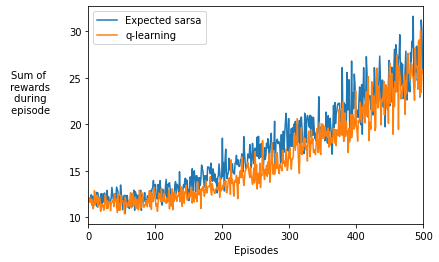

In [ ]:
agent_info = {"num_actions": 2, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0,"seed":1}
n_runs=100
n_episodes=500
env=gym.make('TextFlappyBird-v0', height=15 , width=20 , pipe_gap = 4)
all_reward_sums= []

for run in tqdm(range(n_runs)):
  agent=qlearning_agent()
  agent.agent_init(agent_info)
  agent_info["seed"] = run
  reward_sums = []
  for episode in range(n_episodes):
    init_state=env.reset()
    summ=0
    action=agent.agent_start(init_state)
    while True:
      obs, reward, done, info = env.step(action)
      summ=summ+reward
      action=agent.agent_step(reward,obs)
      if done:
        agent.agent_end(reward)
        break
    reward_sums.append(summ) #for each episode take the sum of rewards
  all_reward_sums.append(reward_sums) #a vector of vectors, that presents the sum of rewards for each episode, for each run
#now lets average it over the runs
mean_rewards_q_learning=np.mean(all_reward_sums, axis=0)
plt.plot(mean_rewards_exp_sarsa, label="Expected sarsa")
plt.plot(mean_rewards_q_learning, label="q-learning")
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,500)

plt.legend()
plt.show()
  
    
env.close()


the graph above shows the sums of reward after x episodes averaged over 100 runs to reduce stochasticity in the plot.<br>
since the game played is flappy bird and the agent will receive a reward as long as it remains alive, we clearly see that there isn't an upper bound of how much reward it can get, so is pretty normal that the sum of rewards will constantly increase with the number of episodes.<br>
As written below we know for sure that the q-learning algorithm is optimal as long as the number of episodes tend to infinite,while sarsa results are suboptimal, so , why in this graph it seems that the epected sarsa performs better? simply because the q-learning algorithm is very slow in convergence, and it needs to do a lot of more exploration before it finds the optimal policy.

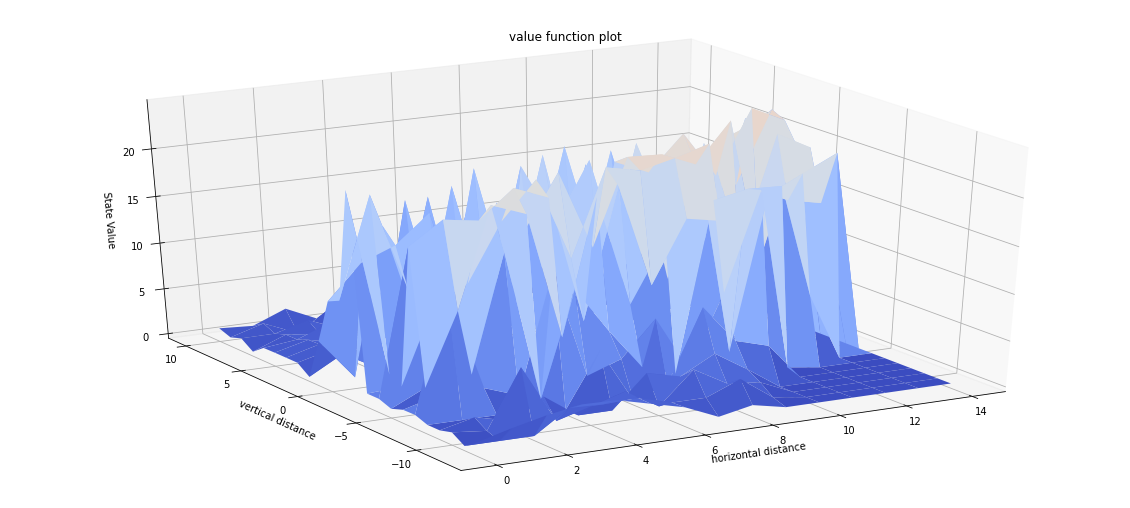

In [ ]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in agent.q.items())
plot_flappy_bird_values(V)

this is the state value function plotted for the q learning agent,as is possible to see there are a lot of more spike and uncertanty in values, but we can clearly see that is in the way of finding the optimal policy

lets now train this too for 2000 episodes as comparison:

100%|██████████| 100/100 [09:03<00:00,  5.43s/it]


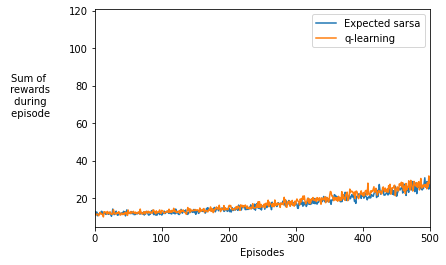

In [ ]:
agent_info = {"num_actions": 2, "epsilon": 0.1, "step_size": 0.5, "discount": 1.0,"seed":1}
n_runs=100
n_episodes=2000
env=gym.make('TextFlappyBird-v0', height=15 , width=20 , pipe_gap = 4)
all_reward_sums= []

for run in tqdm(range(n_runs)):
  agent=qlearning_agent()
  agent.agent_init(agent_info)
  agent_info["seed"] = run
  reward_sums = []
  for episode in range(n_episodes):
    init_state=env.reset()
    summ=0
    action=agent.agent_start(init_state)
    while True:
      obs, reward, done, info = env.step(action)
      summ=summ+reward
      action=agent.agent_step(reward,obs)
      if done:
        agent.agent_end(reward)
        break
    reward_sums.append(summ) #for each episode take the sum of rewards
  all_reward_sums.append(reward_sums) #a vector of vectors, that presents the sum of rewards for each episode, for each run
#now lets average it over the runs
mean_rewards_q_learning=np.mean(all_reward_sums, axis=0)
plt.plot(mean_rewards_exp_sarsa, label="Expected sarsa")
plt.plot(mean_rewards_q_learning, label="q-learning")
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=40)
plt.xlim(0,500)

plt.legend()
plt.show()
  
    
env.close()


In [ ]:
policy = dict((k,np.argmax(v)) for k, v in agent.q.items())

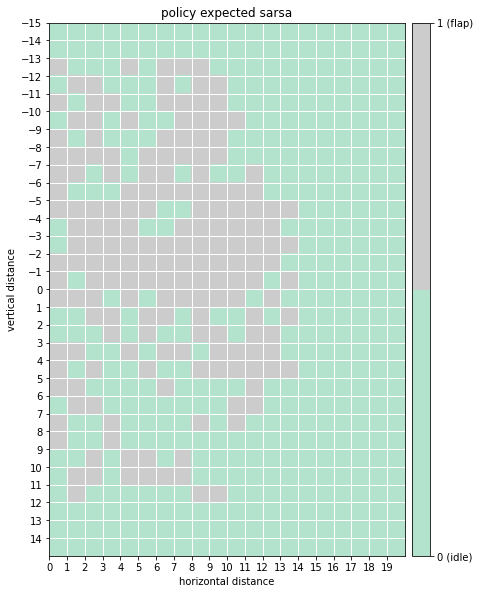

In [ ]:
plot_policy(policy)

100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


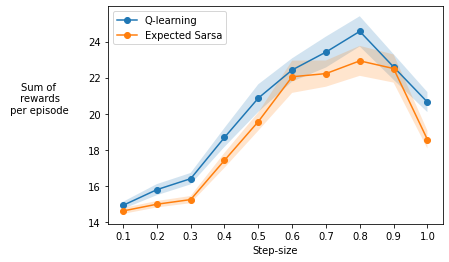

In [ ]:
agents = {
    "Q-learning": qlearning_agent(),
    "Expected Sarsa": ExpectedSarsaAgent()
}
env =gym.make('TextFlappyBird-v0', height=15 , width=20 , pipe_gap = 4)
all_reward_sums = {}
step_sizes = np.linspace(0.1,1.0,10)
agent_info = {"num_actions": 4, "num_states": 48, "epsilon": 0.1, "discount": 1.0}
env_info = {}
num_runs = 100
num_episodes = 700
all_reward_sums = {}

for algorithm in ["Q-learning", "Expected Sarsa"]:
    for step_size in step_sizes:
        all_reward_sums[(algorithm, step_size)] = []
        agent_info["step_size"] = step_size
        for run in tqdm(range(num_runs)):
            agent_info["seed"] = run
            agent=agents[algorithm]
            agent.agent_init(agent_info)

            

            return_sum = 0
            for episode in range(num_episodes):
              init_state=env.reset()
              action=agent.agent_start(init_state)
              while True:
                  obs, reward, done, info = env.step(action)
                  return_sum=return_sum+reward
                  action=agent.agent_step(reward,obs)
                  if done:
                      agent.agent_end(reward)
                      break
              
                
            all_reward_sums[(algorithm, step_size)].append(return_sum/num_episodes)
        

for algorithm in ["Q-learning", "Expected Sarsa"]:
    algorithm_means = np.array([np.mean(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    algorithm_stds = np.array([sem(all_reward_sums[(algorithm, step_size)]) for step_size in step_sizes])
    plt.plot(step_sizes, algorithm_means, marker='o', linestyle='solid', label=algorithm)
    plt.fill_between(step_sizes, algorithm_means + algorithm_stds, algorithm_means - algorithm_stds, alpha=0.2)

plt.legend()
plt.xlabel("Step-size")
plt.ylabel("Sum of\n rewards\n per episode",rotation=0, labelpad=50)
plt.xticks(step_sizes)
plt.show()

this plot represents the mean sum of reward per episode with different step sizes.

Q-learning (and off-policy learning in general) has higher per-episode variance than SARSA, and may suffer from problems converging as a result. but we can see that it will get a higher per sum of rewards if we are using more episodes, whatever is the step size, but if we keep a low number of episodes(in this case 700), we can see that expected sarsa may have a better result

# differencies of the two agents: 

expected sarsa is not being very optimistic because it does not always consider the best future value, instead it considers an outcome based on the current policy. 
sarsa will approach convergence allowing for possible penalties from exploratory moves, whilst q-learning will ignore them. That makes sarsa more conservative - if there is risk of a large negative reward close to the optimal path, q-learning will tend to trigger that reward whilst exploring, whilst sarsa will tend to avoid a dangerous optimal path and only slowly learn to use it when the exploration parameters are reduced. thats the main difference, thats why using sarsa can be extremely useful if, we had an envronment in wich we can have large expenses if we loose (e.g automatic driving) or if, in our case we would pay 1€ every time the bird loses, q-learnign, will try to find the optimal move (even pulling some dangerous actions to get exacly in the middle of the pipe, while sarsa is only interested in passing the pipe)